# TP 2 : Linear regression

## Done By : Adnane El Bouhali

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

##### (1) For the first question, we load a standard dataset from `sklearn.datasets` named `fetch_california_housing`. This dataset has only $( p \approx 8 )$ variables. 
#####  (a) Estimate the coefficients with the expression of the normal equations seen in class. Code two functions to compute 'the MSE' (Mean Squared Error) and the R2 coefficient, and compare them with the version of sklearn for the train and the test sets.

In [48]:
# Load the California housing dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Estimating coefficients using the Normal Equation
# add x0 = 1 to each instance
X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)

# Predictions
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_train_pred = X_b.dot(theta_best)
y_test_pred = X_test_b.dot(theta_best)

In [49]:
def custom_mean_squared_error(y_true, y_pred):
    """
    Calculate the Mean Squared Error (MSE) between true and predicted values.

    MSE is a common regression loss function that measures the average of the squares of the errors,
    which is the average squared difference between the estimated values and the actual value.

    Args:
    y_true (array-like): True values of the dependent variable.
    y_pred (array-like): Predicted values of the dependent variable.

    Returns:
    float: The mean squared error.
    """
    return np.mean(np.square(y_true - y_pred))


def custom_r2_score(y_true, y_pred):
    """
    Calculate the R-squared (R2) score, a statistical measure of how close the data are
    to the fitted regression line.

    R2 represents the proportion of the variance for a dependent variable that's explained
    by an independent variable or variables in a regression model. It is an indication of
    the goodness of fit of the model.

    Args:
    y_true (array-like): True values of the dependent variable.
    y_pred (array-like): Predicted values of the dependent variable.

    Returns:
    float: The R-squared score.
    """
    numerator = np.sum(np.square(y_true - y_pred))
    denominator = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (numerator / denominator)

In [50]:
def compare_metrics(y_train, y_train_pred, y_test, y_test_pred):
    """
    Compare MSE and R2 scores for training and test datasets using custom and sklearn functions.

    Args:
    y_train (array-like): True values for the training set.
    y_train_pred (array-like): Predicted values for the training set.
    y_test (array-like): True values for the test set.
    y_test_pred (array-like): Predicted values for the test set.

    Returns:
    DataFrame: A DataFrame containing MSE and R2 scores for both training and test sets.
    """
    metrics = [
        {
            'Metric': 'MSE',
            'Custom (Train)': custom_mean_squared_error(y_train, y_train_pred),
            'Sklearn (Train)': mean_squared_error(y_train, y_train_pred),
            'Custom (Test)': custom_mean_squared_error(y_test, y_test_pred),
            'Sklearn (Test)': mean_squared_error(y_test, y_test_pred)
        },
        {
            'Metric': 'R2 Score',
            'Custom (Train)': custom_r2_score(y_train, y_train_pred),
            'Sklearn (Train)': r2_score(y_train, y_train_pred),
            'Custom (Test)': custom_r2_score(y_test, y_test_pred),
            'Sklearn (Test)': r2_score(y_test, y_test_pred)
        }
    ]

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(metrics)


pd.set_option('display.float_format', '{:.10f}'.format)
results = compare_metrics(y_train, y_train_pred, y_test, y_test_pred)
results

,Metric,Custom (Train),Sklearn (Train),Custom (Test),Sklearn (Test)
0,MSE,0.5179331255,0.5179331255,0.5558915987,0.5558915987
1,R2 Score,0.6125511914,0.6125511914,0.5757877060,0.5757877060


In both metrics (MSE and R2), the custom implementation and the sklearn library produce the same values on both the training and test sets. This suggests that the custom functions are correctly implemented and yield comparable results to the sklearn library for evaluating the performance of a model.

##### (b) Finally, give the confidence intervals at level 99% for all the coefficients coding the expression for the CI (Confidence Interval) seen in session 3.

### CI for the regression coefficients

Under the Gaussian assumption, since

$$ T_j = \frac{\hat{\theta}_j - \theta^*_j}{\hat{\sigma} \sqrt{(X^T X)^{-1}_{j,j}}} \sim T_{n-p-1} $$

and noting $ t_{1-\alpha/2} $ a quantile of order $ 1 - \alpha/2 $ of the distribution $ T_{n-p-1} $, this is the CI for the quantity $\theta^*_j$.
$$ \left[ \hat{\theta}_j - t_{1-\alpha/2} \hat{\sigma} \sqrt{(X^T X)^{-1}_{j,j}},\ \hat{\theta}_j + t_{1-\alpha/2} \hat{\sigma} \sqrt{(X^T X)^{-1}_{j,j}} \right] $$


In [51]:
# Calculate residuals
residuals = y_train - X_b.dot(theta_best)

# Estimate the variance of the residuals
sigma_hat_squared = residuals.T.dot(
    residuals) / (X_train.shape[0] - X_train.shape[1] - 1)

# Calculate the standard error for each coefficient
variance_theta = np.linalg.inv(X_b.T.dot(X_b)) * sigma_hat_squared
se_theta = np.sqrt(np.diag(variance_theta))

# Determine the t-critical value for a 99% confidence interval
alpha = 0.01  # 99% confidence level
dof = X_train.shape[0] - X_train.shape[1] - 1  # degrees of freedom
t_critical = t.ppf(1 - alpha/2, dof)

# Calculate the confidence intervals
confidence_intervals = [(theta - t_critical * se, theta + t_critical * se)
                        for theta, se in zip(theta_best, se_theta)]

# Creating a DataFrame for a cleaner display
coefficients_df = pd.DataFrame({
    'Coefficient': theta_best,
    '99% Confidence Interval': confidence_intervals
})

# Display the DataFrame
coefficients_df

,Coefficient,99% Confidence Interval
0,-37.0232777054,"(-38.89947812343265, -35.147077287394346)"
1,0.4486749097,"(0.4365966902810837, 0.46075312905452914)"
2,0.0097242575,"(0.00845039301690284, 0.010998122019166386)"
3,-0.1233233428,"(-0.14033325760363824, -0.1063134280572763)"
4,0.7831449068,"(0.6974988719299661, 0.8687909416759633)"
5,-0.0000020296,"(-1.555090937029013e-05, 1.1491668210891732e-05)"
6,-0.0035263185,"(-0.004778818125497191, -0.002273818848810262)"
7,-0.4197924866,"(-0.4402870183956, -0.3992979547663851)"
8,-0.4337080650,"(-0.45514625942651665, -0.41226987048607266)"


##### (2) For the rest of the TP, we use the dataset in eCampus data. Load and preprocess the data:
##### (a) Separate the data into train and test sets: save one fourth of the data for testing (use `train_test_split` from `sklearn.model_selection` with the random seed set to 0). Standardize both the training and testing sets using the `fit_transform` and `transform` functions from `sklearn.preprocessing.StandardScaler`.

In [52]:
# Load the data
file_path = 'data.csv'
df = pd.read_csv(file_path, header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.2981733747,-0.1622490637,1.2233793692,1.3555543396,1.0801706280,0.6349793274,0.2987410831,0.5482702692,0.7317733642,1.0186454353,...,0.5882777993,0.2101056224,1.8614582713,-0.4363994859,0.2792989402,-1.4160197332,-2.3323629080,0.2150961140,-0.6933193671,151.0000000000
1,0.1669509240,-0.3380604547,-0.6188667069,0.7593661939,1.1342806017,-0.5368436568,-0.0751196805,0.9702507047,-0.3274865091,0.7173103926,...,-0.2510538037,-0.8257156925,0.3391389744,1.1194299857,0.2259578884,-0.8222883603,0.3828383031,-0.7188292843,-0.1889933031,75.0000000000
2,-0.4161765519,-0.2056594659,-1.2822259004,1.6755004251,1.5237458086,0.1920285052,-0.2358395147,-1.9546256930,-0.8533093483,0.8927914569,...,1.2838366724,0.3725155107,-0.6525570726,-2.5793471534,0.1392668789,-1.9011963586,0.0482099003,0.2202052031,0.4715877958,141.0000000000
3,0.8671838502,-0.3986671479,0.0935010601,0.0259708006,1.8520992822,0.7897738252,0.8017752505,0.3767108077,0.8536893082,0.2479530403,...,0.4465820041,0.3347331650,0.3990735432,-0.8841723070,0.7238185010,1.3163666265,0.0882175800,0.6194961093,1.0616619142,206.0000000000
4,1.1932818777,-0.9369799631,-0.7250385063,0.7660777798,0.2234889749,-1.5846220462,1.1468658808,0.0861364077,-0.0887803420,-0.9450658776,...,0.7861569973,-1.0581791504,-0.1557875043,-0.6425043504,2.0400101070,-1.7031104749,-1.9015023896,1.7788111721,-0.4898533094,135.0000000000


In [53]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
count,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,...,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000,442.0000000000
mean,0.0000000000,-0.0000000000,0.0000000000,0.0000000000,-0.0000000000,-0.0000000000,0.0000000000,0.0000000000,0.0000000000,-0.0000000000,...,-0.0000000000,0.0000000000,0.0000000000,-0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,152.1334841629
std,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,...,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,1.0011331448,77.0930045330
min,-3.1492473960,-2.8628706902,-3.0575433524,-2.8569030620,-3.1023469781,-2.7823440258,-2.8253184096,-3.6265254134,-2.8340069322,-2.6958606646,...,-3.0594749472,-3.2065388054,-2.5853248927,-3.5617628962,-3.1679615593,-2.7512069614,-3.0289400436,-2.6754469389,-2.9183210399,25.0000000000
25%,-0.6707869977,-0.7128394221,-0.7160981466,-0.6715473679,-0.6732231679,-0.6951003569,-0.6986587005,-0.6387690636,-0.6666746151,-0.6930020951,...,-0.6885118135,-0.5793321313,-0.6282189881,-0.6190945854,-0.7359865524,-0.6374872132,-0.6472738530,-0.7025578047,-0.6378171277,87.0000000000
50%,0.0381950320,0.0621742116,0.0473940562,0.0000656575,-0.0061113149,-0.0134516721,-0.0482305741,0.0401663618,0.0006047571,0.0360240582,...,-0.0299479457,0.0254054021,-0.0222902383,-0.0060877582,0.0076770910,-0.0031236031,0.0244457832,-0.0418783389,-0.0809907524,140.5000000000
75%,0.6748497305,0.6244546967,0.6975120558,0.6881971395,0.7026457130,0.7155790057,0.7200217110,0.5788436150,0.6298078471,0.6629149522,...,0.6672696848,0.6676636060,0.5985076881,0.7406182951,0.7000446645,0.6440061649,0.6313916224,0.6929875850,0.7249268628,211.5000000000
max,2.5470507159,2.5671772183,2.9658243962,3.0576117667,3.1737125875,3.1379498273,3.1992048609,3.6167184553,3.0990899638,3.0325052366,...,2.6774579999,2.8068771511,3.2554622206,2.8119111857,2.8389597690,3.3512543213,2.7344813652,3.6376843105,2.7102603082,346.0000000000


In [54]:
# Assuming the target variable is the last column of the dataset
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Only the last column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

##### (b) Fit a regular OLS.

In [55]:
# Create a Linear Regression model
model = LinearRegression(fit_intercept=False)

# Fit the model to the scaled training data
model.fit(X_train, y_train)

# Make predictions on the scaled training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model on the original scale
mse_lr_train = mean_squared_error(y_train, y_train_pred)
r2_lr_train = r2_score(y_train, y_train_pred)

mse_lr_test = mean_squared_error(y_test, y_test_pred)
r2_lr_test = r2_score(y_test, y_test_pred)

# Print metrics for both train and test sets
print("Train Set - Mean Squared Error:", mse_lr_train)
print("Train Set - R-squared:", r2_lr_train)
print("\nTest Set - Mean Squared Error:", mse_lr_test)
print("Test Set - R-squared:", r2_lr_test)

Train Set - Mean Squared Error: 0.5030414425542292
Train Set - R-squared: 0.4969585574457709

Test Set - Mean Squared Error: 0.6614444347739913
Test Set - R-squared: 0.16680477624214962


The model appears to perform reasonably well on the training set, as evidenced by the relatively low MSE and a moderate R2 score.
However, the drop in performance on the test set (higher MSE and lower R2) suggests that the model may not generalize optimally to new data. This situation might indicate overfitting, where the model has learned the training data too well but struggles with new, unseen data.

## Variable selection

##### (3) Program the method of forward variable selection based on hypothesis tests for regression coefficients. This method starts from an empty set of variables S and, at each iteration, selects one variable relevant for predicting y and includes it in the set S. It runs until a halting condition is met. The coding process is as follows:
##### (a) Develop a function that, given a dataset $( X \in \mathbb{R}^{n \times p} )$ and y, fits $( p )$ linear regression models, each using only feature $( X_j )$ to predict y. For each model, conduct a test of no effect, as discussed in session 3, and compute the p-value of the test. This function should return the coefficient with the smallest p-value. Explain the significance of the p-value in this context.

### Test of no-effect: Gaussian case

Goal: Develop a test of significance level $\alpha$ to check whether $\theta_j^* = 0$

Null hypothesis, $H_0: \theta_j^* = 0$, equivalently, $\Theta_0 = \{\theta \in \mathbb{R}^p: \theta_j = 0\}$

Under $H_0$, we know the value of $\hat{T}_j$:

$$
T_j := \frac{\hat{\theta}_j}{\hat{\sigma}\sqrt{(X^TX)^{-1}_{j,j}}} \sim T_{n-(p+1)}
$$

Choosing $R = [-t_{1-\alpha/2}, t_{1-\alpha/2}]^c$ with $t_{1-\alpha/2}$ the $1 - \alpha/2$-quantile of $T_{n-(p+1)}$, we decide to reject $H_0$ whenever :

$$
|\hat{T}_j| > t_{1-\alpha/2}
$$

The p-value is used as a criterion for selecting variables in a forward variable selection method. Variables with small p-values are considered statistically significant, indicating that they have a strong association with the response variable and are more likely to be included in the model. This helps in building a parsimonious model with the most relevant variables for predicting the response.

In [56]:
def test_all_effects(X, y):
    """
    Tests the statistical significance of each feature in a dataset using linear regression.

    Args:
    X (array-like): A 2D array with shape (n_samples, n_features) containing the input features.
    y (array-like): A 1D array containing the target variable.

    Returns:
    tuple: A tuple containing two elements:
        - A list of p-values for each feature's significance test.
        - The index of the best feature with the lowest p-value.
    """
    p_values = []
    best_feature = None
    best_p_value = float('inf')
    for feature in range(X.shape[1]):
        # Fit the model using only the current feature
        model = LinearRegression(fit_intercept=False).fit(
            X[:, feature].reshape(-1, 1), y)
        # Estimate the coefficient and standard error
        coef = model.coef_[0]
        y_pred = model.predict(X[:, feature].reshape(-1, 1))
        residuals = y - y_pred
        s_squared = np.sum(residuals**2) / (len(y) - 1)
        X_squared_sum = np.sum(X[:, feature]**2)
        std_err = np.sqrt(s_squared / X_squared_sum)
        # Calculate t-statistic
        t_stat = coef / std_err
        # Degrees of freedom
        df = len(y) - 1
        # Calculate two-tailed p-value
        p_value = 2 * (1 - t.cdf(np.abs(t_stat), df))
        p_values.append(p_value)
        if (p_value) < best_p_value:
            best_p_value = p_value
            best_feature = feature
    return p_values, best_feature

##### (b) Apply the function iteratively. At each iteration, select the feature $( X_f )$ with the smallest p-value and:
 1. Include it in the set $( S )$.
 2. Remove it from $( X )$.
 3. Subtract from $( y )$ the residuals of the model fit with feature $( X_f )$. Elaborate on the reason for subtracting the residuals.

Subtracting residuals is a crucial step in the forward variable selection method to iteratively refine the response variable, isolating unexplained variation attributed to the newly added features. This process contributes to building a more accurate and focused model with a parsimonious set of relevant features.

##### (c) Add a halting condition to the algorithm: Stop adding features to the set $( S )$ when the p-value exceeds 0.05. Plot the p-values for every coefficient for the first 5 iterations (all in the same plot).

In [57]:
# Iterative forward selection function
def iterative_forward_selection(X, y):
    """
    Perform iterative forward selection on a dataset to select features based on statistical significance.

    Args:
    X (array-like): A 2D array with shape (n_samples, n_features) containing the input features.
    y (array-like): A 1D array containing the target variable.
    num_iterations (int, optional): The number of iterations to perform. Defaults to 5.

    Returns:
    tuple: A tuple containing two elements:
        - A list of indices of the selected features.
        - A history of p-values for each iteration.
    """
    selected_features = []  # List to store indices of selected features
    p_values_history = []  # List to store p-values from each iteration

    X_new = X.copy()  # Create a copy of the input features

    while (X_new.shape[1] > 0):  # Iterate through the specified number of iterations
        p_values, best_feature = test_all_effects(X_new, y)
        p_values_history.append(p_values)
        # Fit model and get residuals
        model = LinearRegression().fit(
            X_new[:, best_feature].reshape(-1, 1), y)
        residuals = y - model.predict(X_new[:, best_feature].reshape(-1, 1))
        y = residuals  # Update y by subtracting the residuals
        # Remove the selected feature from X
        X_new = np.delete(X_new, best_feature, axis=1)
        selected_features.append(best_feature)
        if (p_values[best_feature] > 0.05):
            break

    return selected_features, p_values_history

##### Plot the p-values for every coefficient for the first 5 iterations (all in the same plot).

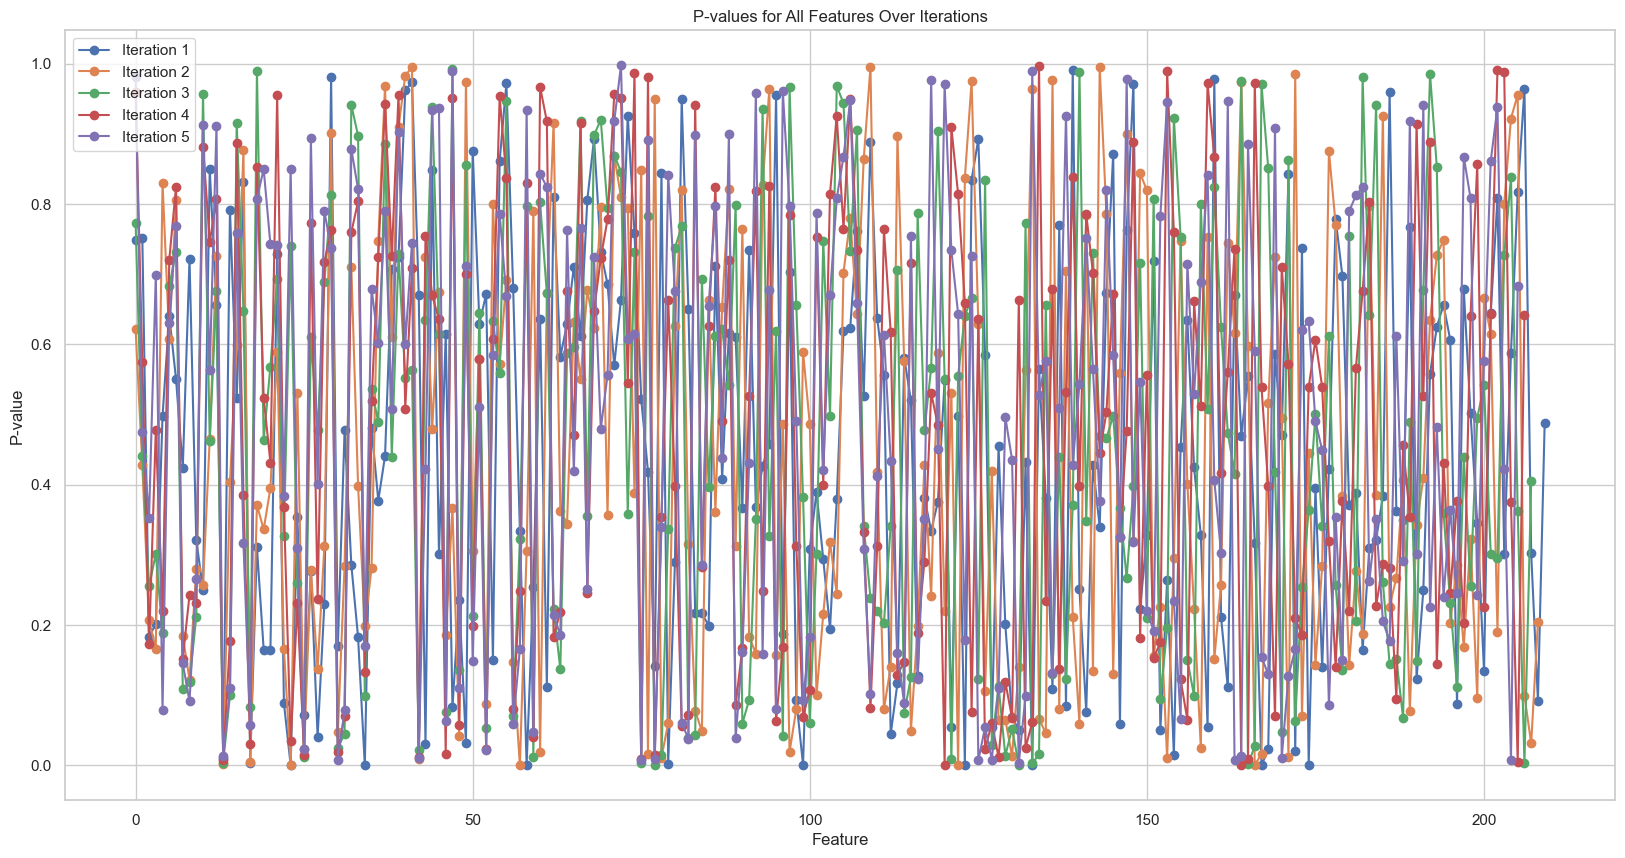

Selected features: [34, 57, 77, 120, 131, 162, 30, 74, 160, 165, 123, 172, 13, 195]


In [58]:
# Perform iterative forward selection on the training data
selected_features, p_values_history = iterative_forward_selection(
    X_train, y_train)

# Plot p-values for each iteration
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.plot(p_values_history[i], marker='o', label=f'Iteration {i+1}')
plt.title('P-values for All Features Over Iterations')
plt.xlabel('Feature')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)  # Add grid
plt.show()

# Print selected features
print("Selected features:", selected_features)

## Extensions

##### (4) Run ridge regression using scikit-learn on the training set. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $( 10^{-1} )$ and $( 10^6 )$. Display two subplots at the end:
##### (a) The first subplot should show the evolution of the coefficients for each different value of the penalty parameter. 
##### (b) The second subplot should display the evolution of the R-squared coefficient at each of the 30 iterations.
##### Since we are going to perform similar tasks for Lasso and Elastic Net, it is mandatory to write this code as an independent function that can be parameterized for each specific case.

In [59]:
def run_regression_analysis(model_type, alpha_range, X_train, y_train, X_test, y_test):
    """
    Run a regression analysis with varying alpha (regularization strength) and plot the results.

    Args:
    model_type (class): The type of regression model (e.g., Lasso, Ridge).
    alpha_range (iterable): A range of alpha values to test.
    X_train (array-like): Training set features.
    y_train (array-like): Training set target variable.
    X_test (array-like): Test set features.
    y_test (array-like): Test set target variable.

    Returns:
    tuple: A tuple containing the minimum MSE score and the maximum R-squared score for both training and test sets.
    """

    coefs = []
    r2_train_scores = []
    mse_train_scores = []  # Add a list to store training MSE scores
    r2_test_scores = []
    mse_test_scores = []  # Add a list to store test MSE scores

    # Iterate over the range of alpha values
    for alpha in alpha_range:
        # Adding a small value to alpha to avoid extremely high regularization for Lasso
        model = model_type(alpha=alpha)
        model.fit(X_train, y_train)
        coefs.append(model.coef_)

        # Predictions and scores on the training set
        y_train_pred = model.predict(X_train)
        r2_train_scores.append(r2_score(y_train, y_train_pred))
        # Calculate and store training MSE scores
        mse_train_scores.append(mean_squared_error(y_train, y_train_pred))

        # Predictions and scores on the test set
        y_test_pred = model.predict(X_test)
        r2_test_scores.append(r2_score(y_test, y_test_pred))
        # Calculate and store test MSE scores
        mse_test_scores.append(mean_squared_error(y_test, y_test_pred))

    coefs = np.array(coefs)

    # Plotting the results (you may choose to remove this if not needed)
    # Increase the number of subplots to accommodate MSE scores
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plotting coefficients
    ax[0].plot(alpha_range, coefs.reshape(-1, X.shape[1]))
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Alpha')
    ax[0].set_ylabel('Coefficients')
    ax[0].set_title(
        f'{model_type.__name__} Coefficients as a function of Alpha')

    # Plotting R-squared values
    ax[1].plot(alpha_range, r2_train_scores, label='Train Set')
    ax[1].plot(alpha_range, r2_test_scores, label='Test Set')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Alpha')
    ax[1].set_ylabel('R-squared')
    ax[1].set_title(
        f'R-squared for different values of Alpha in {model_type.__name__}')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Return the minimum MSE and maximum R-squared scores for both training and test sets
    return min(mse_train_scores), max(r2_train_scores), min(mse_test_scores), max(r2_test_scores)

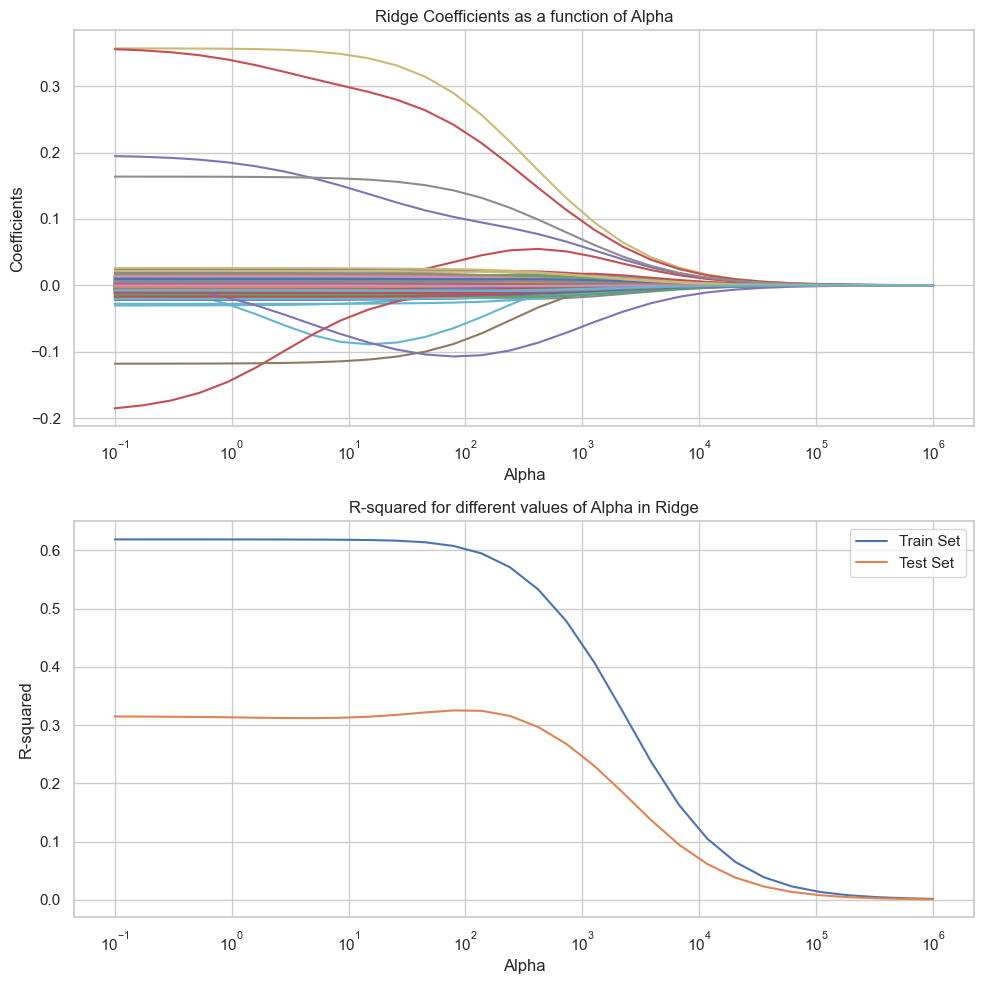

In [60]:
# Create a range of alpha values to test
ridge_alphas = np.logspace(-1, 6, 30)

# Run the Ridge regression analysis
mse_ridge_train, r2_ridge_train, mse_ridge_test, r2_ridge_test = run_regression_analysis(
    Ridge, ridge_alphas, X_train, y_train, X_test, y_test)

##### (5) Run the code for Lasso as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $( 10^{-3} )$ and $( 10^2 )$.

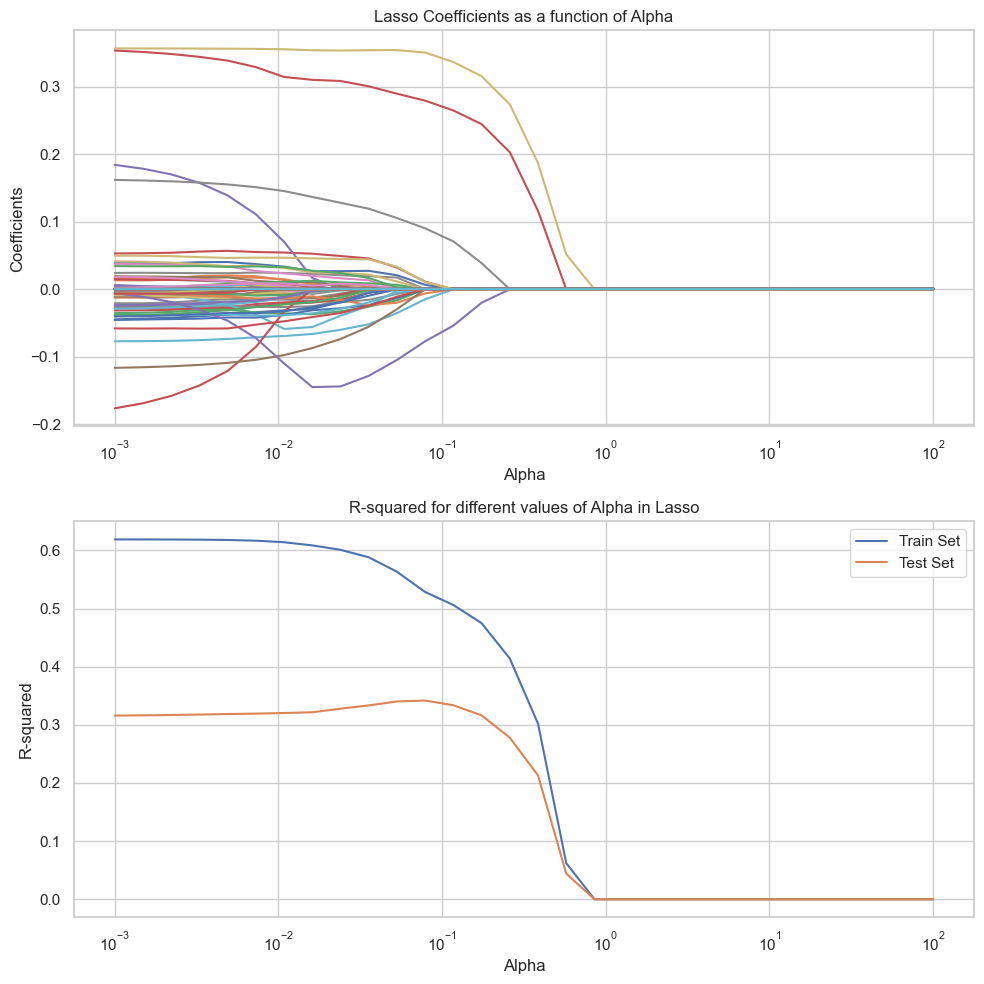

In [61]:
# Define alpha range for Lasso
lasso_alphas = np.logspace(-3, 2, 30)

# Run the Lasso regression analysis
mse_lasso_train, r2_lasso_train, mse_lasso_test, r2_lasso_test = run_regression_analysis(
    Lasso, lasso_alphas, X_train, y_train, X_test, y_test)

6) Run the code for ElasticNet as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $( 10^{-3} )$ and $( 10^2 )$.

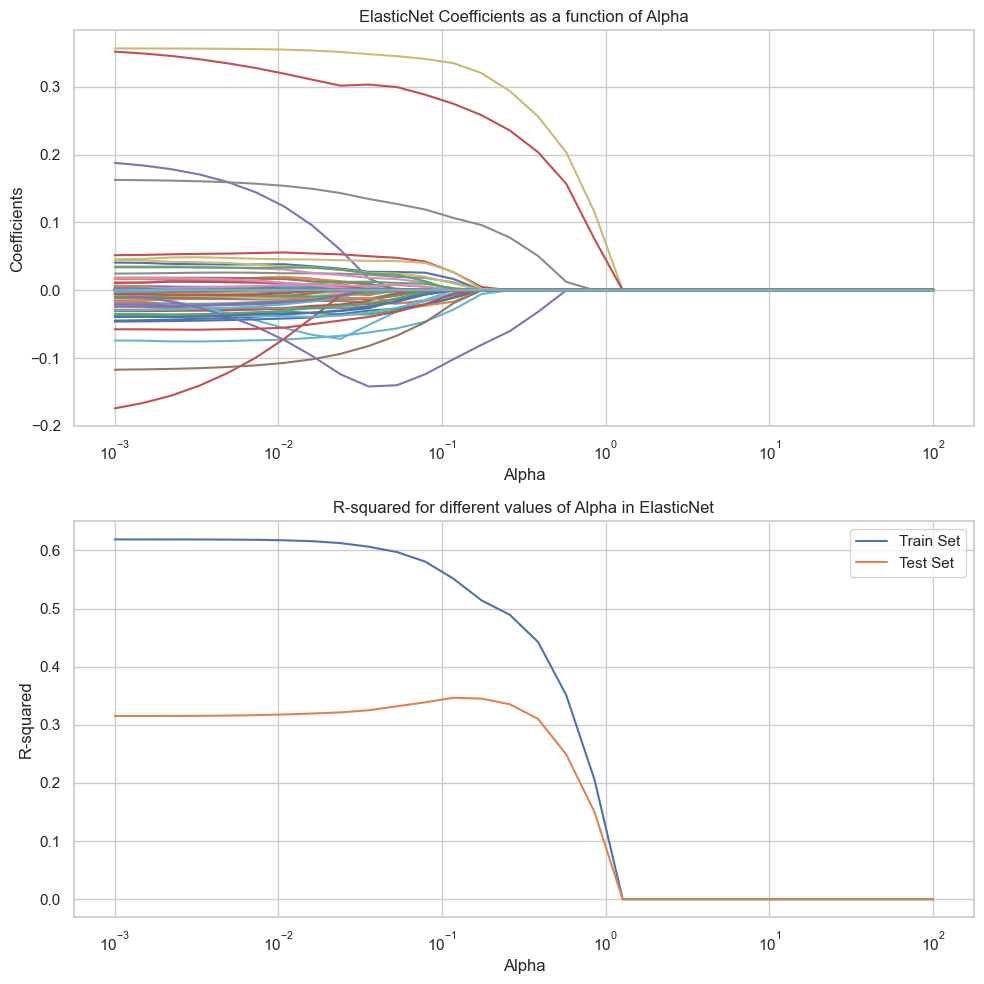

In [62]:
# Define alpha range for ElasticNet
elasticnet_alphas = np.logspace(-3, 2, 30)

# Run the ElasticNet regression analysis
mse_elastic_train, r2_elastic_train, mse_elastic_test, r2_elastic_test = run_regression_analysis(
    ElasticNet, elasticnet_alphas, X_train, y_train, X_test, y_test)

##### (7) Compute the singular value decomposition of the covariance matrix. For consistency in the notation use $( U )$, $( s )$, $( V )$ from $( \text{SVD}(X^J X) )$.
##### (a) Plot a heatmap of the covariance matrix.

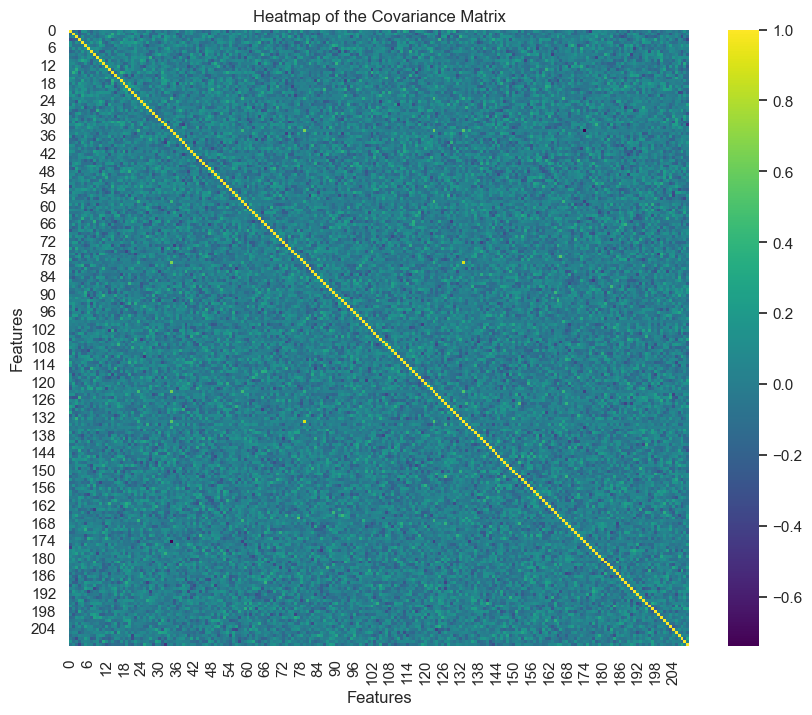

In [63]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

# Compute the covariance matrix
cov_matrix = X.T.dot(X) / X.shape[0]

# Plotting the heatmap of the covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=False, cmap='viridis')
plt.title("Heatmap of the Covariance Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

##### The data appears to have many features that are not strongly correlated with one another. This could be beneficial for certain types of analyses or models that assume feature independence.

##### (b) Compute the PCA (Principal Component Analysis) for the data using the SVD (Singular Value Decomposition).

In [64]:
# Perform Singular Value Decomposition
U, s, V = np.linalg.svd(cov_matrix)

# Sort the singular values in descending order
sorted_indices = np.argsort(s)[::-1]
s_sorted = s[sorted_indices]
V_sorted = V[sorted_indices, :]

# Select the first two principal components
principal_components_2 = V_sorted[:2, :]

# Project the data onto these components
X_projected_2 = np.dot(X, principal_components_2.T)

# Project the data onto all the principal component
principal_components = V.T[sorted_indices]
X_projected = np.dot(X, principal_components)

##### (c) Plot the amount of variance explained by the first $( k )$ components for $( k \in \{2, \dots, p\} )$. How many variables do we need to explain more than 90% of the variance?

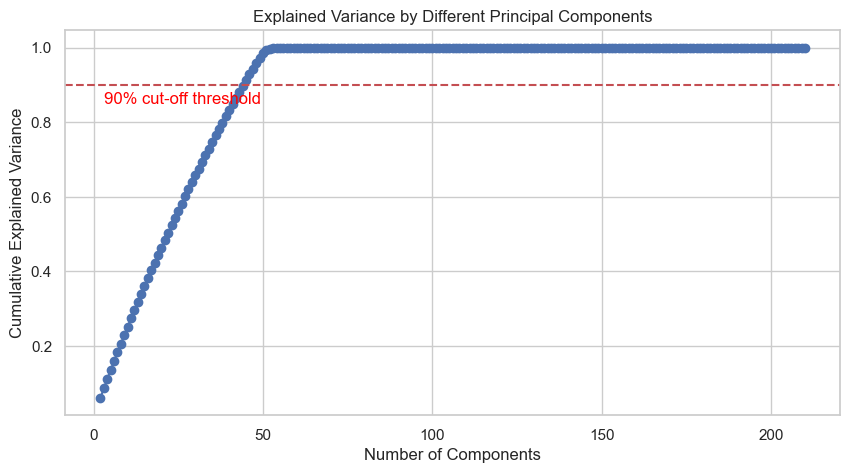

Number of components needed to explain 90% variance: 45


In [65]:
# Calculate the variance explained by each principal component
explained_variance = (s**2) / (len(X_projected) - 1)
total_variance = sum(explained_variance)
explained_variance_ratio = explained_variance / total_variance

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting for k in range [2, p]
plt.figure(figsize=(10, 5))
plt.plot(range(2, len(cumulative_explained_variance) + 1),
         cumulative_explained_variance[1:], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.grid(True)

# Show a horizontal line at 90% variance
plt.axhline(y=0.9, color='r', linestyle='--')
plt.text(3, 0.85, '90% cut-off threshold', color='red', fontsize=12)

plt.show()

# Find the number of components for 90% variance
num_components_90_variance = np.where(cumulative_explained_variance >= 0.9)[
    0][1]  # Start from the second component
print(
    f'Number of components needed to explain 90% variance: {num_components_90_variance}')

##### Overall, the data suggests that while more complex models with more features or components can capture more variance and fit the training data better, they do not necessarily generalize well to unseen data (overfitting). Dimensionality reduction through PCA can effectively reduce the number of features while retaining most of the information. However, the choice of the number of components to use in a regression model should consider both the explained variance and the model's predictive performance on unseen data.

(d) Plot the projected data with $( k \geq 2 )$ using as color the value of $( y )$ and interpret the plot.

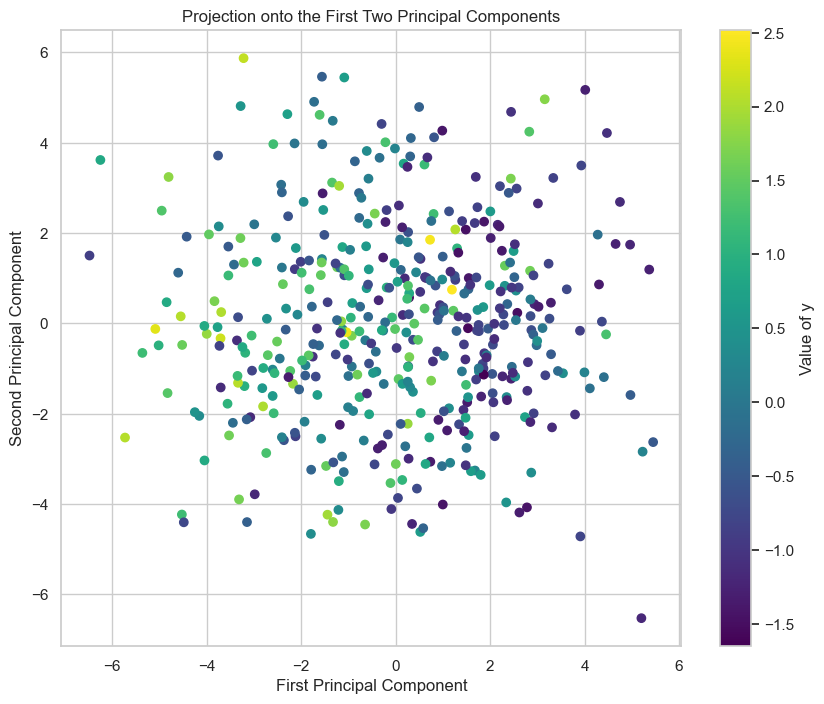

In [66]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_projected_2[:, 0],
                      X_projected_2[:, 1], c=y, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Projection onto the First Two Principal Components')
plt.colorbar(scatter, label='Value of y')
plt.grid(True)
plt.show()

The plot doesn't reveal a distinct gradient or discernible color pattern indicative of a robust linear relationship between the principal components and the target variable $y$. The points exhibit somewhat random coloring, implying that any relationship, if present, might be non-linear or necessitate consideration of additional components beyond the first two to comprehend the association with $y$. Nevertheless, there is a subtle clustering of yellow and green points (representing higher $y$ values) towards the plot's center. This concentration suggests a potential region of increased density for larger $y$ values or hints at the possibility of a non-linear relationship.

##### (e) Plot the the two first principal directions.

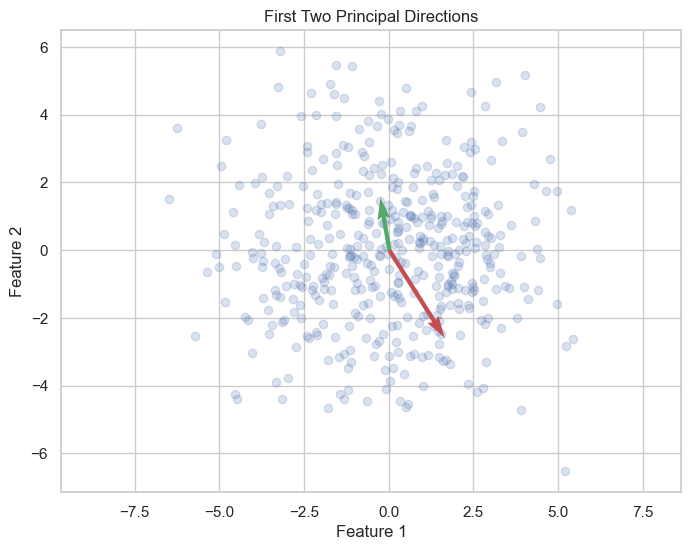

In [67]:
# Calculate the mean of the data
mean_vals = np.mean(X_projected_2, axis=0)

# Get the first two principal components
pc1 = V.T[:, 0]
pc2 = V.T[:, 1]

# Scale the principal components (optional, for better visualization)
scale_factor = 50  # Adjust as needed
pc1_scaled = pc1 * scale_factor
pc2_scaled = pc2 * scale_factor

# Plot
plt.figure(figsize=(8, 6))
# Plotting only the first two features
plt.scatter(X_projected_2[:, 0], X_projected_2[:, 1], alpha=0.2)

# Plot the principal components as vectors
plt.quiver(mean_vals[0], mean_vals[1], pc1_scaled[0], pc1_scaled[1],
           angles='xy', scale_units='xy', scale=1, color='r', width=0.007)
plt.quiver(mean_vals[0], mean_vals[1], pc2_scaled[0], pc2_scaled[1],
           angles='xy', scale_units='xy', scale=1, color='g', width=0.007)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('First Two Principal Directions')
plt.grid(True)
plt.axis('equal')
plt.show()

##### (f) Run OLS on the projected data (PCR) using $( k )$ components for $( k \leq 50 )$. Select the $( k )$ that returns the best score of the OLS model and plot the evolution of the scores with $( k )$.


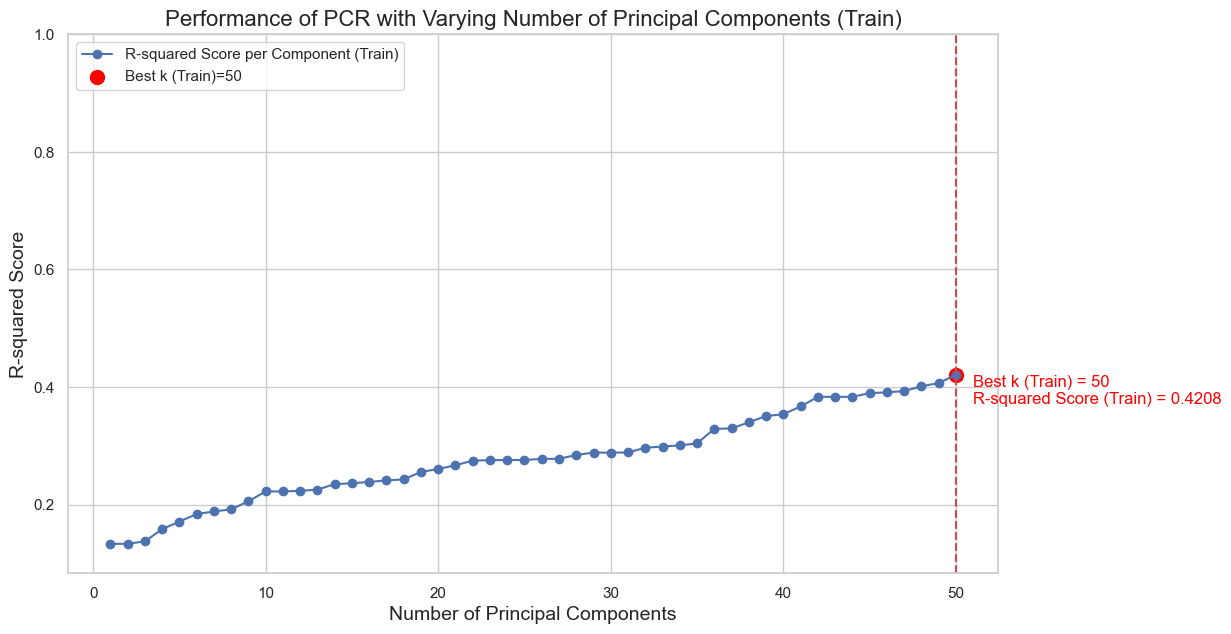

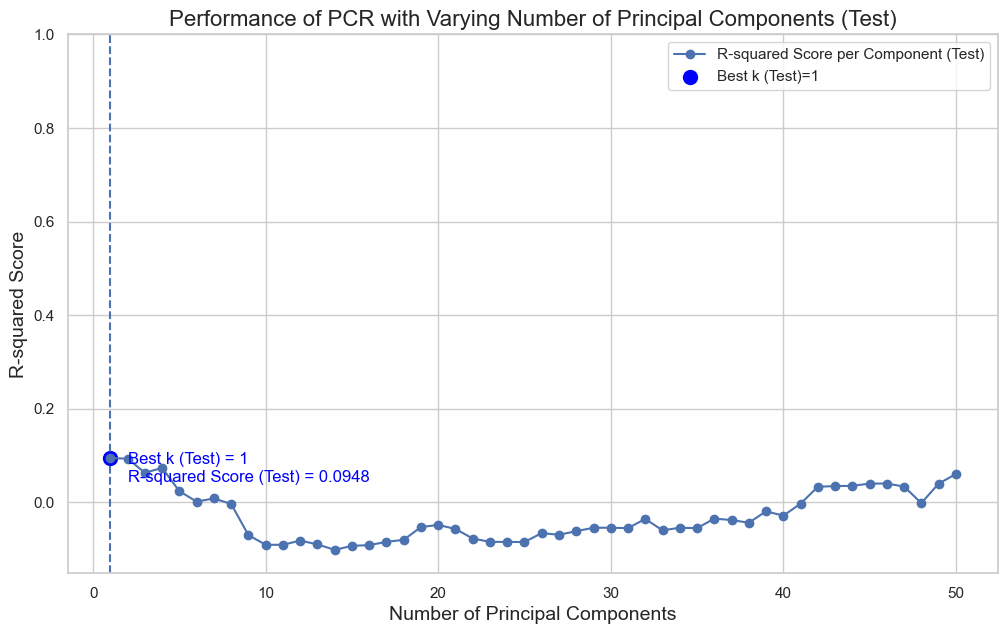

In [68]:
components_range = range(1, 51)  # Adjust range as needed

# Initialize lists to store scores and the corresponding number of components
r2_train_scores = []
r2_test_scores = []
mse_train_scores = []
mse_test_scores = []

X_train_projected = np.dot(X_train, principal_components)
X_test_projected = np.dot(X_test, principal_components)

# Loop over the number of components
for k in components_range:

    # Project the data onto the first k principal components
    X_train_pca_k = X_train_projected[:, :k]
    X_test_pca_k = X_test_projected[:, :k]

    # Fit OLS model on the training set
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train_pca_k, y_train)
    y_train_pred_pca = model.predict(X_train_pca_k)
    y_test_pred_pca = model.predict(X_test_pca_k)

    # Calculate and store the training score
    r2_train_scores.append(r2_score(y_train, y_train_pred_pca))
    r2_test_scores.append(r2_score(y_test, y_test_pred_pca))
    mse_train_scores.append(mean_squared_error(y_train, y_train_pred_pca))
    mse_test_scores.append(mean_squared_error(y_test, y_test_pred_pca))

# Find the number of components with the best training score and mse
best_score_train_pca = max(r2_train_scores)
best_score_test_pca = max(r2_test_scores)
best_mse_train_pca = min(mse_train_scores)
best_mse_test_pca = min(mse_test_scores)
best_k_train = components_range[r2_train_scores.index(best_score_train_pca)]
best_k_test = components_range[r2_test_scores.index(best_score_test_pca)]


plt.figure(figsize=(12, 7))
plt.plot(components_range, r2_train_scores, marker='o',
         label='R-squared Score per Component (Train)')
plt.scatter(best_k_train, best_score_train_pca, color='red', s=100,
            label=f'Best k (Train)={best_k_train}')  # Highlight the best training score
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('R-squared Score', fontsize=14)
plt.title('Performance of PCR with Varying Number of Principal Components (Train)', fontsize=16)
plt.axvline(x=best_k_train, color='r', linestyle='--')
plt.text(best_k_train + 1, best_score_train_pca - 0.05,
         f'Best k (Train) = {best_k_train}\nR-squared Score (Train) = {best_score_train_pca:.4f}', color='red', fontsize=12)
plt.grid(True)
# Adjust y-axis limits to reflect R-squared
plt.ylim([min(r2_train_scores) - 0.05, 1])
plt.legend()
plt.show()

# Plotting the evolution of scores with k for the test set
plt.figure(figsize=(12, 7))
plt.plot(components_range, r2_test_scores, marker='o',
         label='R-squared Score per Component (Test)')
plt.scatter(best_k_test, best_score_test_pca, color='blue', s=100,
            label=f'Best k (Test)={best_k_test}')  # Highlight the test score
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('R-squared Score', fontsize=14)
plt.title(
    'Performance of PCR with Varying Number of Principal Components (Test)', fontsize=16)
plt.axvline(x=best_k_test, color='b', linestyle='--')  # Use blue for test set
plt.text(best_k_test + 1, best_score_test_pca - 0.05,
         f'Best k (Test) = {best_k_test}\nR-squared Score (Test) = {best_score_test_pca:.4f}', color='blue', fontsize=12)
plt.grid(True)
# Adjust y-axis limits to reflect R-squared
plt.ylim([min(r2_test_scores) - 0.05, 1])
plt.legend()
plt.show()

The training graph indicates that including more principal components captures more complexity of the training data, hence the increase in R-squared. However, this does not necessarily translate to better generalization on unseen data, as evidenced by the test data results.

The test graph suggests that the model is overfitting when more than one principal component is used, as the R-squared score is highest with only one component and then decreases with more components. This implies that while the model becomes more complex and fits the training data better with more components, it does not generalize well to the test data.

The optimal number of principal components for the test data is just one, as adding more components does not improve the model's performance on the test data.

There is a significant discrepancy between the performance on training and test datasets, which strongly suggests overfitting. When the number of components is optimized for the training set, it performs poorly on the test set.
The model's complexity should be re-evaluated to find a better balance that allows the model to generalize better to new, unseen data.

It's important to note that while R-squared is a useful metric for assessing model fit, it doesn't always tell the whole story, especially for the test data where predictive performance is crucial. Other metrics like Mean Squared Error (MSE) or Mean Absolute Error (MAE) could also be considered for a more comprehensive evaluation.

## Comparison of the models

##### (8) Summarize the results of the models and elaborate in their main characteristics. Plot all the training and testing errors for all the models considered and elaborate on the results.

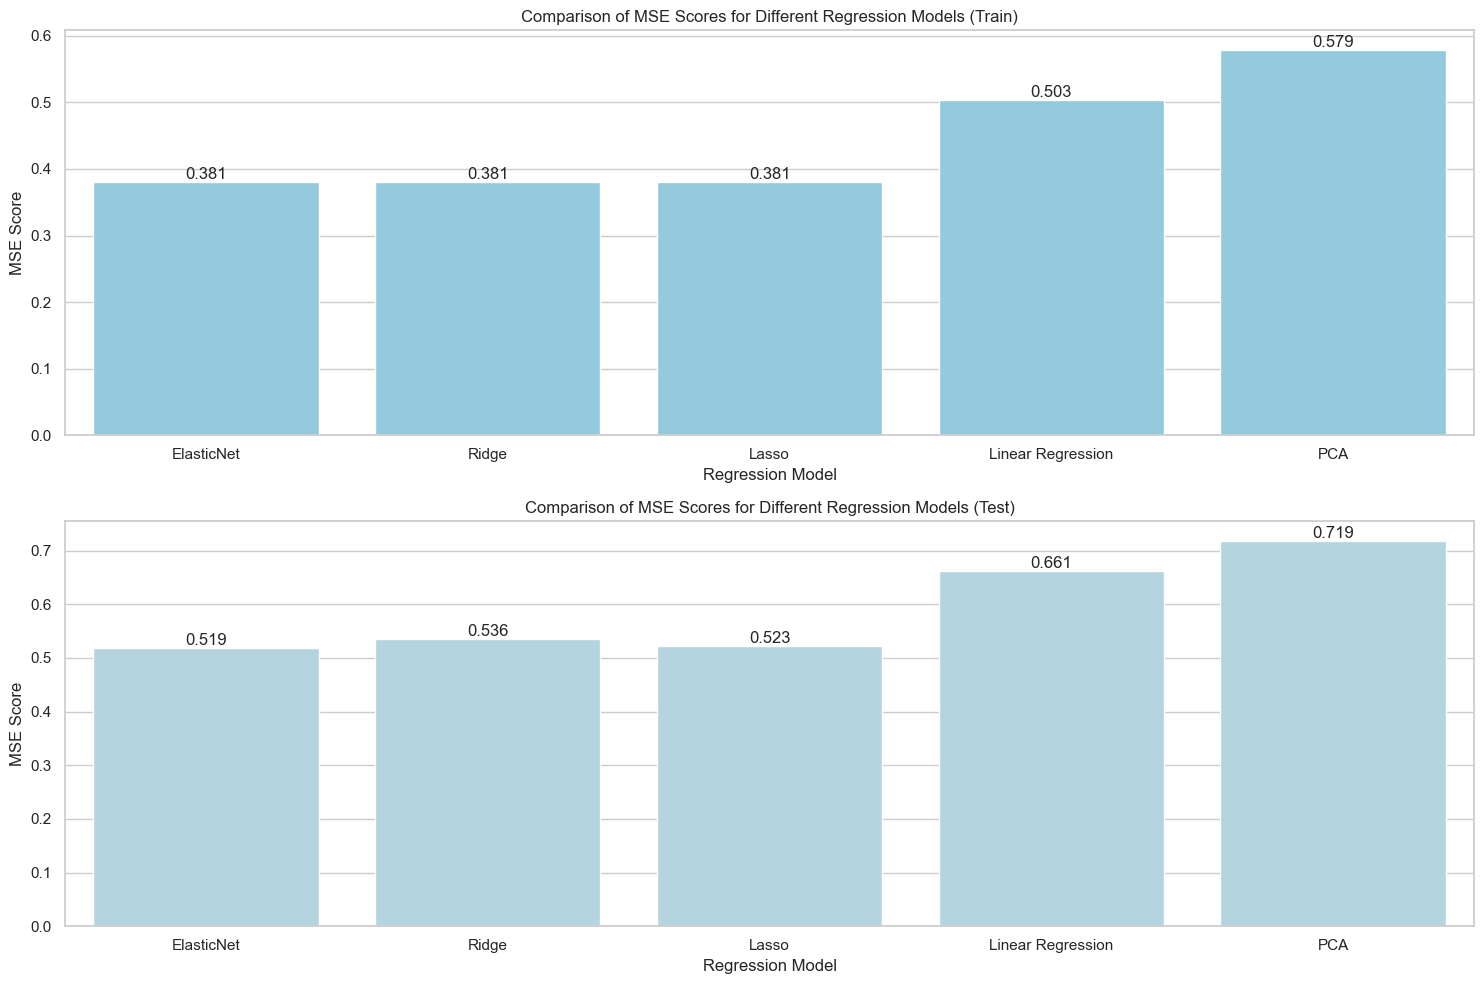

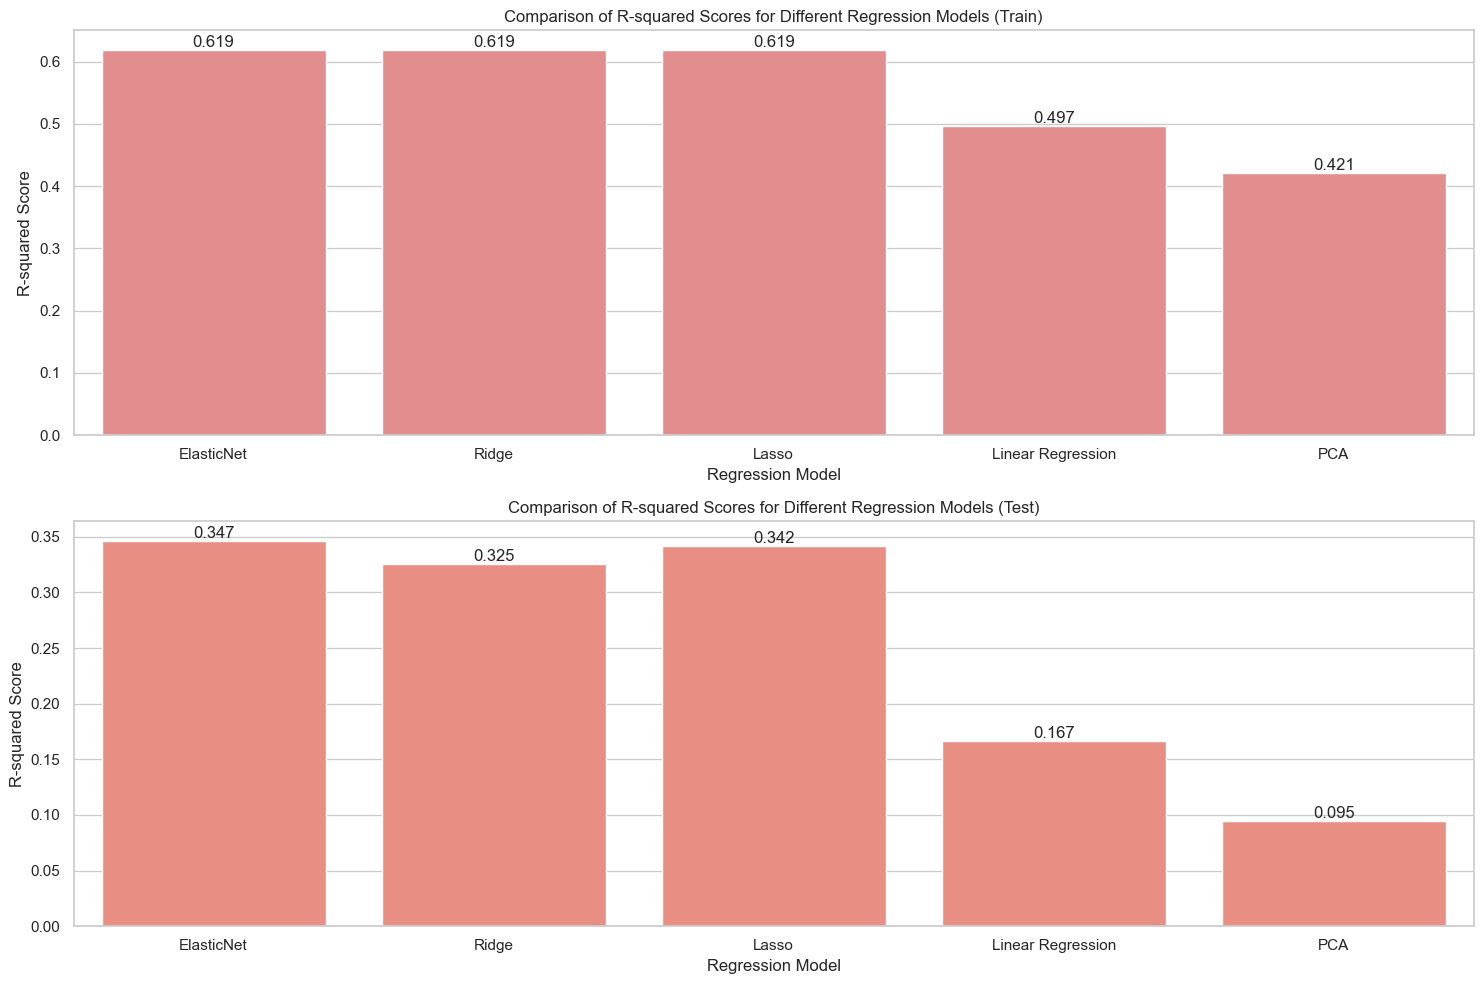

In [69]:
# Models list and scores
models = ['ElasticNet', 'Ridge', 'Lasso', 'Linear Regression', 'PCA']
mse_train_scores = [mse_elastic_train, mse_ridge_train,
                    mse_lasso_train, mse_lr_train, best_mse_train_pca]
mse_test_scores = [mse_elastic_test, mse_ridge_test,
                   mse_lasso_test, mse_lr_test, best_mse_test_pca]

r2_train_scores = [r2_elastic_train, r2_ridge_train,
                   r2_lasso_train, r2_lr_train, best_score_train_pca]
r2_test_scores = [r2_elastic_test, r2_ridge_test,
                  r2_lasso_test, r2_lr_test, best_score_test_pca]

# Set the style
sns.set(style="whitegrid")

# Plot the MSE scores for Train and Test
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# MSE Train plot
sns.barplot(x=models, y=mse_train_scores, color="skyblue",
            ax=ax[0])  # Set a constant color
ax[0].set_title(
    'Comparison of MSE Scores for Different Regression Models (Train)')
ax[0].set_xlabel('Regression Model')
ax[0].set_ylabel('MSE Score')
for i, score in enumerate(mse_train_scores):
    ax[0].text(i, score, round(score, 3), ha='center', va='bottom')

# MSE Test plot
sns.barplot(x=models, y=mse_test_scores, color="lightblue",
            ax=ax[1])  # Set a constant color
ax[1].set_title(
    'Comparison of MSE Scores for Different Regression Models (Test)')
ax[1].set_xlabel('Regression Model')
ax[1].set_ylabel('MSE Score')
for i, score in enumerate(mse_test_scores):
    ax[1].text(i, score, round(score, 3), ha='center', va='bottom')

# Adjust layout for MSE plots
plt.tight_layout()
plt.show()

# Plot the R-squared scores for Train and Test
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# R-squared Train plot
sns.barplot(x=models, y=r2_train_scores, color="lightcoral",
            ax=ax[0])  # Set a constant color
ax[0].set_title(
    'Comparison of R-squared Scores for Different Regression Models (Train)')
ax[0].set_xlabel('Regression Model')
ax[0].set_ylabel('R-squared Score')
for i, score in enumerate(r2_train_scores):
    ax[0].text(i, score, round(score, 3), ha='center', va='bottom')

# R-squared Test plot
sns.barplot(x=models, y=r2_test_scores, color="salmon",
            ax=ax[1])  # Set a constant color
ax[1].set_title(
    'Comparison of R-squared Scores for Different Regression Models (Test)')
ax[1].set_xlabel('Regression Model')
ax[1].set_ylabel('R-squared Score')
for i, score in enumerate(r2_test_scores):
    ax[1].text(i, score, round(score, 3), ha='center', va='bottom')

# Adjust layout for R-squared plots
plt.tight_layout()
plt.show()

When it comes to the train set:

ElasticNet and Ridge Regression have identical MSE and R-squared scores for the training set, suggesting they perform equally well on the training data. This could indicate that the penalty terms in these models are set in such a way that they end up with similar complexity or that the features do not benefit from the lasso part of the ElasticNet (since Ridge is a special case of ElasticNet with no lasso penalty).

Lasso Regression has the same MSE as ElasticNet and Ridge for the training set but a slightly better R-squared score, which suggests it might be capturing the variance in the data slightly better, potentially due to feature selection properties of the Lasso.

Linear Regression has higher MSE and lower R-squared scores on the training set compared to the other models, indicating it fits the training data worse than the regularized models.

PCA seems to refer to a model where PCA was used for dimensionality reduction before applying a regression model. It has the highest MSE and lowest R-squared score on the training data, indicating the worst fit among the models considered.

When it comes to the test set:

All models show a decrease in performance from the training set to the test set, which is expected due to overfitting to the training data. However, the degree of overfitting varies between models.

ElasticNet seems to have the best generalization on the test set as it has the lowest MSE and the highest R-squared score, though the difference in MSE is not very large.

Linear Regression experiences a significant drop in R-squared from training to testing, and its MSE increases substantially, suggesting it may be the most overfit model out of those considered.

PCA has the worst generalization on the test set with the highest MSE and the lowest R-squared score. This indicates that the dimensionality reduction may have removed too much useful information or that the reduced features do not generalize well to unseen data.

Overall, based on the test set performance, ElasticNet seems to be the most reliable model with consistent MSE and R-squared scores between training and testing. It suggests a good balance between bias and variance, avoiding overfitting while still capturing the underlying pattern in the data.